### Import Modules

In [ ]:
# import modules
import os # file 
import shutil
import cv2 # opencv for images
import random
import numpy as np
import pandas as pd
import torch
from ultralytics import YOLO #for obeject detection
import albumentations as A # for image augmentation
from albumentations.pytorch import ToTensorV2 # for image formating
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import seaborn as sns
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")



### Data organization
- Auto-annotated datasets: For images annotated with pre-trained model
- Manually-annotated datasets: For images annotated manually
- Raw Images Datasets: Contains images not annotated

In [12]:
# create direcories to organize images and cleanup for to avoid duplicate images 
dataset_base_dir = "../datasets"

# auto-annotated directories
auto_annotated_images_dir = os.path.join(dataset_base_dir, "auto_annotated/images")
auto_annotated_labels_dir = os.path.join(dataset_base_dir, "auto_annotated/labels")


# manually annotated directories
manual_train_images_dir = os.path.join(dataset_base_dir, "manually_annotated/images/train")
manual_train_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/labels/train")

manual_val_images_dir = os.path.join(dataset_base_dir, "manually_annotated/images/val")
manual_val_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/labels/val")

# source directory containing all raw manually annotated images
manual_source_images_dir = os.path.join(dataset_base_dir, "manually_annotated/raw_images")
manual_source_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/raw_labels")


# source directory containing all raw unannotated images 
raw_images_dir = os.path.join(dataset_base_dir, "raw_images")



def reset_directories(directories):
    """
    Check if the specified directories exist. If they do, delete them and recreate them.
    Ensures the directories are clean before use.

    Parameters:
        directories (list): List of directories to reset.
    """
    for path in directories:
        dir_path = os.path.join(dataset_base_dir, path)
        if os.path.exists(dir_path):
            # delete the directory and all its contents
            try:
                shutil.rmtree(dir_path)
                print(f"Deleted existing directory: {dir_path}")
            except Exception as e:
                print(f"Failed to delete {dir_path}. Reason: {e}")
        
        # Recreate the directory
        try:
            os.makedirs(dir_path, exist_ok=True)
            print(f"Recreated directory: {dir_path}")
        except Exception as e:
            print(f"Failed to create directory {dir_path}. Reason: {e}")

# Define directories to reset
directories_to_reset = [
    auto_annotated_images_dir,
    auto_annotated_labels_dir,


    # manually annotated directories
    manual_train_images_dir,
    manual_train_labels_dir,
    manual_val_images_dir,
    manual_val_labels_dir 
]

# Reset directories
reset_directories(directories_to_reset)
print("Directories reset and ready for use.")

# Set random seed for reproducibility
random.seed(42)

Deleted existing directory: ../datasets/../datasets/auto_annotated/images
Recreated directory: ../datasets/../datasets/auto_annotated/images
Deleted existing directory: ../datasets/../datasets/auto_annotated/labels
Recreated directory: ../datasets/../datasets/auto_annotated/labels
Deleted existing directory: ../datasets/../datasets/manually_annotated/images/train
Recreated directory: ../datasets/../datasets/manually_annotated/images/train
Deleted existing directory: ../datasets/../datasets/manually_annotated/labels/train
Recreated directory: ../datasets/../datasets/manually_annotated/labels/train
Deleted existing directory: ../datasets/../datasets/manually_annotated/images/val
Recreated directory: ../datasets/../datasets/manually_annotated/images/val
Deleted existing directory: ../datasets/../datasets/manually_annotated/labels/val
Recreated directory: ../datasets/../datasets/manually_annotated/labels/val
Directories reset and ready for use.


### Random Image Visualization

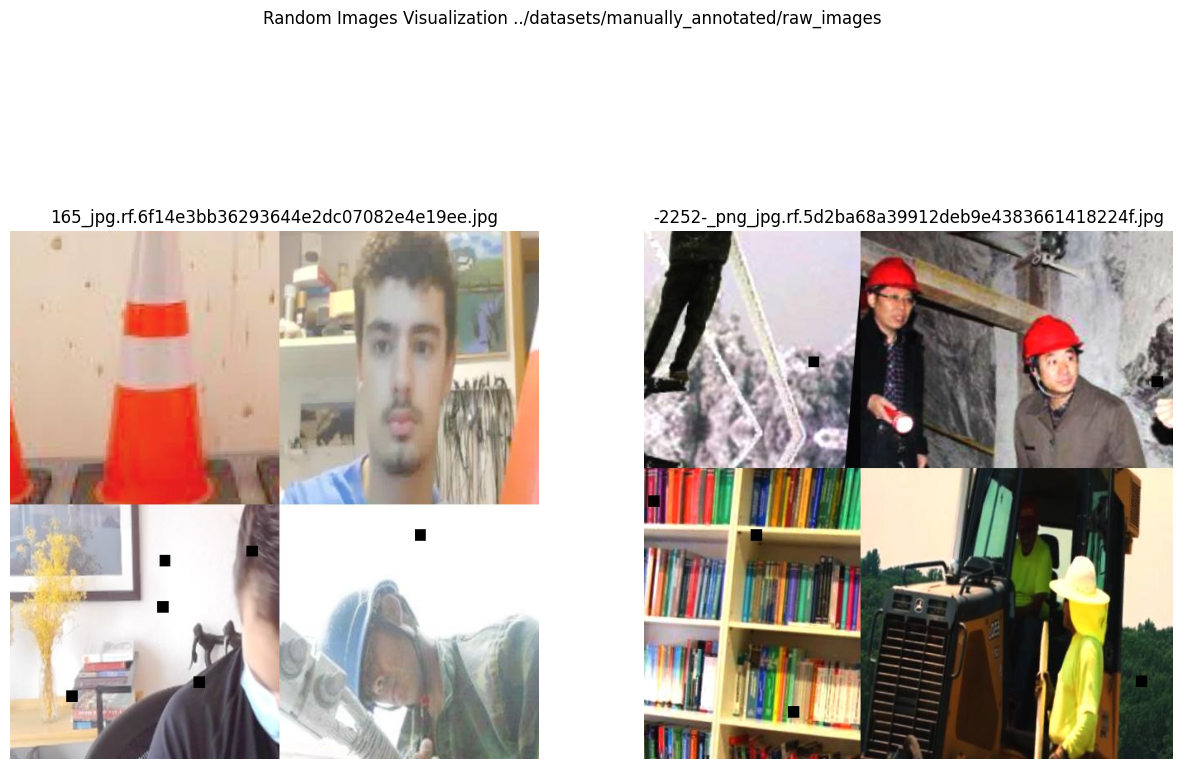

In [13]:
# define function to visualize random images
def visualize_images(images_dir, num_images=5):
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(15, 10))
    for i, image_file in enumerate(selected_files):
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(image_file)
    plt.suptitle(f"Random Images Visualization {images_dir}")
    plt.show()
    
visualize_images(manual_source_images_dir, num_images=2)

### Image Properties

In [14]:
# define function to analyze image properties (dimensions, aspect ratio)
def analyze_image_properties(images_dir):
    properties = {"filename": [], "width": [], "height": [], "aspect_ratio": []}

    for image_file in os.listdir(images_dir):
        if image_file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(images_dir, image_file)
            image = cv2.imread(image_path)
            height, width = image.shape[:2]
            aspect_ratio = width / height
            properties["filename"].append(image_file)
            properties["width"].append(width)
            properties["height"].append(height)
            properties["aspect_ratio"].append(aspect_ratio)

    # convert to pandas DataFrame for analysis
    df = pd.DataFrame(properties)
    return df
print("Image Properties Analysis Of Manually Labeled Images")
analyze_image_properties(manual_source_images_dir)


Image Properties Analysis Of Manually Labeled Images


filename  width  height  \
0        2_jpg.rf.b6161c4d7722be0e92af7b88e8391da5.jpg    640     640   
1                                     scene3_all_4.jpg    640     640   
2                                    scene1_none_4.jpg    640     640   
3    4c43875bc97cdaece84ac6ce555235f1_jpg.rf.8bffc5...    640     640   
4    youtube-446_jpg.rf.b9d9b80538b79252761946ece0b...    640     640   
..                                                 ...    ...     ...   
173  -1975-_png_jpg.rf.d6c068e0d3eebc3b8e002413529c...    640     640   
174      2_jpg.rf.2a2cafa3fd6db594c2f3a46f971b1c14.jpg    640     640   
175                                  scene2_mask_1.jpg    640     640   
176    165_jpg.rf.8e28e2ec55d7ab727f8a5cd072024dd2.jpg    640     640   
177  youtube-470_jpg.rf.6aebf4cfb6c5a7e703c6532ca50...    640     640   

     aspect_ratio  
0             1.0  
1             1.0  
2             1.0  
3             1.0  
4             1.0  
..            ...  
173           1.0  
174           1.0  
175           1.0  
176           1.0  
177           1.0  

[178 rows x 4 columns]

### Split manually annotated datasets to train and val

In [15]:
# define function to split manually annotated dataset into train and valation sets
def split_manual_dataset(images_dir, labels_dir, split_ratio=0.8):
    image_files = [
        f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    random.shuffle(image_files)

    train_size = int(split_ratio * len(image_files))
    train_files = image_files[:train_size]
    val_files = image_files[train_size:]
    # manual_train_images_dir = os.path.join(dataset_base_dir, "manually_annotated/images/train")
    # manual_train_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/labels/train")
    # manual_val_images_dir = os.path.join(dataset_base_dir, "manually_annotated/images/val")
    # manual_val_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/labels/val")


    # copy train files and corresponding labels
    for file in train_files:
        label_file = os.path.splitext(file)[0] + ".txt"  # Match label file name with image file name
        image_src = os.path.join(images_dir, file)
        label_src = os.path.join(labels_dir, label_file)
        shutil.copy(image_src, os.path.join(manual_train_images_dir, file))
        shutil.copy(label_src, os.path.join(manual_train_labels_dir, label_file))

    # copy val files and corresponding labels
    for file in val_files:
        label_file = os.path.splitext(file)[0] + ".txt"  # Match label file name with image file name
        image_src = os.path.join(images_dir, file)
        label_src = os.path.join(labels_dir, label_file)
        shutil.copy(image_src, os.path.join(manual_val_images_dir, file))
        shutil.copy(label_src, os.path.join(manual_val_labels_dir, label_file))

    print("Manual dataset split completed. Images and labels copied to train and val directories.")

split_manual_dataset(manual_source_images_dir, manual_source_labels_dir)


Manual dataset split completed. Images and labels copied to train and val directories.


### Train model with manually annotated datasets

In [ ]:
# Train the generic model on manually labeled data
def train_model(manual_train_images, manual_val_images, epochs=50):
    # Create dataset.yaml file for training
    dataset_yaml = "../models/manual_datasets.yaml"
    
    # Train the model
    print("Training model on manually labeled dataset...")
    model = YOLO("yolov8m.pt")
    model.train(
        data=dataset_yaml,
        epochs=50,
        imgsz=640,
        batch=16,
        lr0=1e-4,  # Learning rate 
        optimizer="auto",  # Use AdamW optimizer
        patience=10
    )
    print("Model training completed.")
    return model

# Train the model on the manual dataset
trained_model = train_model(manual_train_images_dir, manual_val_images_dir)


Training model on manually labeled dataset...


100%|██████████| 49.7M/49.7M [00:01<00:00, 36.9MB/s]


New https://pypi.org/project/ultralytics/8.3.37 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.33 🚀 Python-3.11.9 torch-2.5.1 CPU (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=../models/manual_datasets.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_t

train: Scanning /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/datasets/manually_annotated/labels/train.cache... 142 images, 4 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/datasets/manually_annotated/labels/val.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]

Plotting labels to runs/detect/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.629      3.637      1.681        297        640: 100%|██████████| 9/9 [02:28<00:00, 16.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.83s/it]

                   all         36        402       0.68      0.167      0.194      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.362      2.138      1.505        241        640: 100%|██████████| 9/9 [02:27<00:00, 16.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.87s/it]

                   all         36        402      0.335      0.386      0.304       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.278      1.784      1.425        193        640: 100%|██████████| 9/9 [02:27<00:00, 16.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.75s/it]

                   all         36        402      0.567      0.384        0.4      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.257      1.631      1.381        184        640: 100%|██████████| 9/9 [02:26<00:00, 16.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.61s/it]

                   all         36        402      0.454      0.406      0.376      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.218      1.443      1.351        236        640: 100%|██████████| 9/9 [02:27<00:00, 16.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.78s/it]

                   all         36        402      0.542      0.448      0.451      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.188      1.404      1.344        288        640: 100%|██████████| 9/9 [02:28<00:00, 16.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.57s/it]

                   all         36        402      0.548      0.374      0.406      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.202      1.352      1.348        188        640: 100%|██████████| 9/9 [02:26<00:00, 16.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.60s/it]

                   all         36        402      0.423       0.48      0.414      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.203      1.295       1.35        193        640: 100%|██████████| 9/9 [02:26<00:00, 16.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.58s/it]

                   all         36        402      0.568      0.355      0.379      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.244      1.372      1.387        265        640: 100%|██████████| 9/9 [02:26<00:00, 16.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.58s/it]

                   all         36        402      0.623      0.386      0.447      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.195      1.305      1.367        259        640: 100%|██████████| 9/9 [02:27<00:00, 16.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.51s/it]

                   all         36        402      0.488      0.421      0.435      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G       1.17      1.236      1.354        220        640: 100%|██████████| 9/9 [02:28<00:00, 16.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.59s/it]

                   all         36        402      0.582      0.407      0.454      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.177      1.186      1.318        210        640: 100%|██████████| 9/9 [02:27<00:00, 16.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.51s/it]

                   all         36        402      0.637      0.414      0.455      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.138      1.163      1.304        221        640: 100%|██████████| 9/9 [02:27<00:00, 16.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.44s/it]

                   all         36        402      0.593      0.407      0.437      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.091      1.071      1.254        274        640: 100%|██████████| 9/9 [02:27<00:00, 16.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.57s/it]

                   all         36        402      0.785       0.38      0.458      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.092      1.105       1.29        232        640: 100%|██████████| 9/9 [02:27<00:00, 16.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.44s/it]

                   all         36        402      0.577      0.472      0.482      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.079      1.101      1.274        169        640: 100%|██████████| 9/9 [02:27<00:00, 16.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.46s/it]

                   all         36        402      0.582      0.547      0.542      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G       1.04      1.002      1.264        267        640: 100%|██████████| 9/9 [02:26<00:00, 16.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.44s/it]

                   all         36        402      0.549      0.533      0.546      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.075      1.072      1.278        198        640: 100%|██████████| 9/9 [02:25<00:00, 16.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.42s/it]

                   all         36        402      0.703      0.407      0.493      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.008      0.955      1.219        124        640: 100%|██████████| 9/9 [02:26<00:00, 16.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.44s/it]

                   all         36        402      0.547      0.512        0.5      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.008     0.9485       1.21        342        640: 100%|██████████| 9/9 [02:26<00:00, 16.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.47s/it]

                   all         36        402      0.614      0.498      0.541      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.024     0.9306      1.215        287        640: 100%|██████████| 9/9 [13:03<00:00, 87.10s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.34s/it]

                   all         36        402      0.705      0.528      0.578      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      0.963     0.8866      1.193        284        640: 100%|██████████| 9/9 [18:41<00:00, 124.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.70s/it]

                   all         36        402      0.745      0.488      0.576       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.9499     0.8987      1.187        216        640: 100%|██████████| 9/9 [17:55<00:00, 119.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.61s/it]

                   all         36        402      0.684       0.52      0.578      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.9755     0.8833      1.183        179        640: 100%|██████████| 9/9 [04:30<00:00, 30.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.56s/it]

                   all         36        402      0.752      0.543      0.613      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.9293     0.8481      1.167        224        640: 100%|██████████| 9/9 [04:25<00:00, 29.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.84s/it]

                   all         36        402       0.62      0.516      0.543      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.8751     0.7917      1.148        203        640: 100%|██████████| 9/9 [04:47<00:00, 31.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:27<00:00, 13.83s/it]

                   all         36        402      0.619      0.516      0.554      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.8967     0.7718      1.142        334        640: 100%|██████████| 9/9 [04:56<00:00, 32.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.72s/it]

                   all         36        402      0.684      0.526      0.582      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.8754     0.7799      1.131        171        640: 100%|██████████| 9/9 [04:53<00:00, 32.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.92s/it]

                   all         36        402      0.605       0.63      0.608      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G       0.86     0.7497      1.142        183        640: 100%|██████████| 9/9 [04:53<00:00, 32.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.93s/it]

                   all         36        402      0.718      0.594      0.639      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.8677     0.7673      1.139        258        640: 100%|██████████| 9/9 [04:47<00:00, 31.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:25<00:00, 12.54s/it]

                   all         36        402      0.668      0.614      0.642      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.8359     0.7204      1.103        213        640: 100%|██████████| 9/9 [04:42<00:00, 31.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [13:11<00:00, 395.78s/it]

                   all         36        402      0.654      0.598      0.639      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.8033     0.6921      1.097        219        640: 100%|██████████| 9/9 [05:03<00:00, 33.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [08:19<00:00, 249.68s/it]

                   all         36        402      0.809      0.541      0.652      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.8198     0.6849       1.11        247        640: 100%|██████████| 9/9 [02:29<00:00, 16.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.75s/it]

                   all         36        402      0.649      0.641      0.655      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.7695      0.611       1.06        194        640: 100%|██████████| 9/9 [03:23<00:00, 22.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.89s/it]

                   all         36        402      0.725      0.634      0.665       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.8013     0.6653      1.103        241        640: 100%|██████████| 9/9 [03:33<00:00, 23.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.17s/it]

                   all         36        402      0.758      0.637      0.685      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.7606     0.6264      1.071        227        640: 100%|██████████| 9/9 [03:56<00:00, 26.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.99s/it]

                   all         36        402      0.826      0.609      0.685      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.7505     0.6418      1.077        289        640: 100%|██████████| 9/9 [04:00<00:00, 26.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.09s/it]

                   all         36        402      0.808      0.624       0.69      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.7275     0.6043      1.048        222        640: 100%|██████████| 9/9 [04:00<00:00, 26.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.98s/it]

                   all         36        402      0.802      0.608      0.691      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.7549     0.6074      1.051        171        640: 100%|██████████| 9/9 [03:59<00:00, 26.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:21<00:00, 10.92s/it]

                   all         36        402      0.683      0.649      0.678      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.7245     0.5878      1.053        226        640: 100%|██████████| 9/9 [03:59<00:00, 26.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.12s/it]

                   all         36        402      0.763      0.654      0.703      0.441


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      0.739     0.6002      1.068        182        640: 100%|██████████| 9/9 [04:03<00:00, 27.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.08s/it]

                   all         36        402      0.771      0.683      0.716      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.7407     0.5704      1.086        169        640: 100%|██████████| 9/9 [04:00<00:00, 26.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.15s/it]

                   all         36        402      0.796      0.668      0.724      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.7126     0.5495      1.053        131        640: 100%|██████████| 9/9 [04:06<00:00, 27.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.33s/it]

                   all         36        402      0.762      0.633      0.701      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      0.665      0.508      1.021        137        640: 100%|██████████| 9/9 [04:09<00:00, 27.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.28s/it]

                   all         36        402      0.754      0.628      0.697       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.6407     0.4671      1.001        134        640: 100%|██████████| 9/9 [04:12<00:00, 28.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.41s/it]

                   all         36        402      0.754       0.64      0.699      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.6404     0.4704      1.005        121        640: 100%|██████████| 9/9 [04:12<00:00, 28.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.45s/it]

                   all         36        402      0.858      0.573      0.697      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.6175      0.448     0.9828        119        640: 100%|██████████| 9/9 [35:16<00:00, 235.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.30s/it]

                   all         36        402      0.848      0.597      0.706       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.6054       0.43     0.9836        144        640: 100%|██████████| 9/9 [02:27<00:00, 16.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.62s/it]

                   all         36        402      0.838      0.607      0.713      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.6159     0.4583          1        142        640: 100%|██████████| 9/9 [02:40<00:00, 17.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.99s/it]

                   all         36        402      0.822      0.619      0.708      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.6027     0.4359     0.9766        167        640: 100%|██████████| 9/9 [03:29<00:00, 23.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.20s/it]

                   all         36        402      0.815      0.623       0.71      0.464



50 epochs completed in 4.610 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.33 🚀 Python-3.11.9 torch-2.5.1 CPU (Apple M3 Pro)
Model summary (fused): 218 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.23s/it]


                   all         36        402      0.839      0.607      0.712      0.469
               Hardhat         21         46      0.905      0.621      0.788      0.525
                  Mask         17         19       0.79      0.684        0.8      0.557
            NO-Hardhat         21         34      0.852      0.588      0.601       0.36
               NO-Mask         26         57      0.701      0.404      0.427      0.191
        NO-Safety Vest         24         53      0.869        0.5      0.647      0.361
                Person         36        117      0.917      0.735      0.815      0.579
           Safety Cone          7         10      0.824        0.6      0.782       0.54
           Safety Vest         20         39      0.965      0.711      0.876       0.56
             Machinery         11         23      0.784      0.474      0.525       0.43
               Vehicle          3          4      0.784       0.75      0.856      0.588
Speed: 0.5ms preproce

### Load pre-trained model to automatically annotate datasets in raw_images_dir path

In [ ]:
# load the pre-trained model to auto annotated the raw_images
model_path = "runs/detect/train/weights/best.pt"  # Path to your trained YOLO model
auto_annotated_images_dir = os.path.join(dataset_base_dir, "auto_annotated/images")
auto_annotated_labels_dir = os.path.join(dataset_base_dir, "auto_annotated/labels")

def auto_annotate_images(model_path, raw_images_dir, output_images_dir, output_labels_dir, confidence_threshold=0.5):
    """
    Automatically annotate images using a pre-trained YOLO model.

    Args:
    - model_path (str): Path to the trained YOLO model.
    - raw_images_dir (str): Path to the directory containing raw images.
    - output_images_dir (str): Path to save annotated images.
    - output_labels_dir (str): Path to save annotation labels in YOLO format.
    - confidence_threshold (float): Minimum confidence score to include a detection.
    """
    # load the pre-trained model
    model = YOLO(model_path)

    # Create output directories if they don't exist
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    # Loop through all images in the raw images directory
    for image_file in os.listdir(raw_images_dir):
        if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(raw_images_dir, image_file)
            results = model(image_path)  # Perform inference

            # Save the original image to the output directory
            output_image_path = os.path.join(output_images_dir, image_file)
            cv2.imwrite(output_image_path, cv2.imread(image_path))

            # Prepare the YOLO format label file
            label_file = os.path.splitext(image_file)[0] + ".txt"
            output_label_path = os.path.join(output_labels_dir, label_file)

            with open(output_label_path, "w") as f:
                for result in results[0].boxes:
                    box = result.xywhn[0].cpu().numpy()  # Normalized x_center, y_center, width, height
                    class_id = int(result.cls[0].cpu().numpy())
                    confidence = float(result.conf[0].cpu().numpy())

                    # Filter by confidence threshold
                    if confidence >= confidence_threshold:
                        f.write(f"{class_id} {box[0]:.3f} {box[1]:.3f} {box[2]:.3f} {box[3]:.3f}\n")

    print(f"Auto-annotation completed. Annotated images and labels saved in {output_images_dir} and {output_labels_dir}.")

auto_annotate_images(model_path, raw_images_dir, auto_annotated_images_dir, auto_annotated_labels_dir)


image 1/1 /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/notebooks/../datasets/raw_images/IMG_3103_mp4-15_jpg.rf.50d17fb072207d6adc1aa10293ea50bd.jpg: 640x640 1 Mask, 1 NO-Hardhat, 4 Persons, 1 Safety Vest, 2 Machinerys, 181.5ms
Speed: 0.6ms preprocess, 181.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/notebooks/../datasets/raw_images/construction-246-_jpg.rf.fd9bfe8b6726e60a3a00b7f7b03cb7e8.jpg: 640x640 1 NO-Mask, 1 Person, 3 Machinerys, 171.2ms
Speed: 0.6ms preprocess, 171.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/notebooks/../datasets/raw_images/RPReplay_Final1667001201_MP4-100_jpg.rf.9a1b50c4301c53b3ae534c6353337df9.jpg: 640x640 1 Mask, 1 NO-Hardhat, 1 

### Visualize auto-annotated datasets for model accuracy

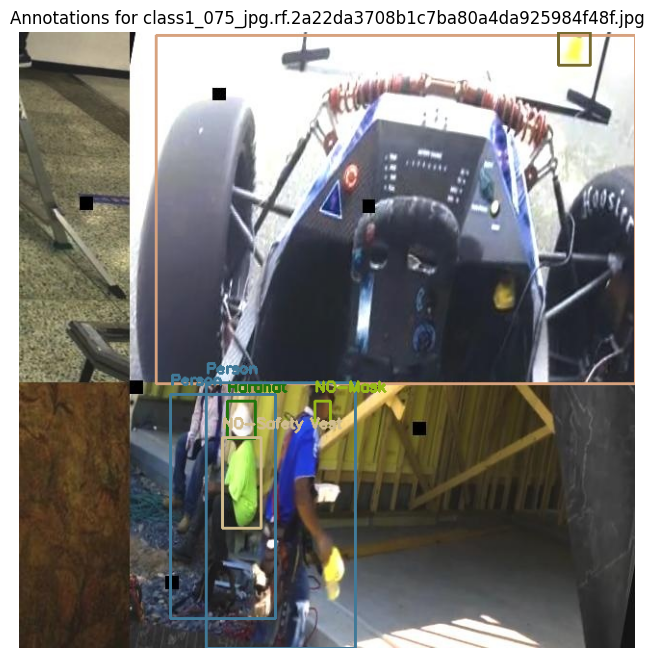

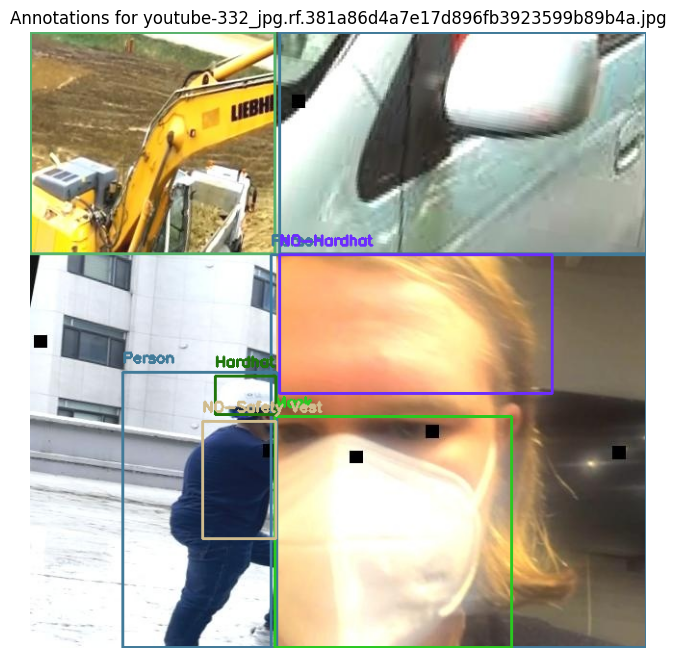

In [159]:
# visualize auto-annotation to ensure correct bounding
def visualize_annotations(image_dir, label_dir, class_names, num_images=5):
    """
    Visualize YOLO-format annotations on images.

    Args:
    - image_dir (str): Path to the directory containing annotated images.
    - label_dir (str): Path to the directory containing YOLO-format label files.
    - class_names (list): List of class names corresponding to class IDs.
    - num_images (int): Number of images to visualize.
    """

    num_classes = len(class_names)
    colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(num_classes)]

    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Select a subset of images to visualize
    image_files = random.sample(image_files, min(num_images, len(image_files)))

    for image_file in image_files:
        # Read the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image: {image_file}")
            continue

        # Convert the image to RGB for visualization
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(label_dir, label_file)
        if not os.path.exists(label_path):
            print(f"Label file not found for image: {image_file}")
            continue

        with open(label_path, "r") as f:
            labels = f.readlines()

        # Overlay bounding boxes and class names on the image
        for label in labels:
            label_data = label.strip().split()
            class_id = int(label_data[0])
            x_center, y_center, width, height = map(float, label_data[1:])

            # Convert normalized YOLO coordinates to image pixel coordinates
            img_height, img_width, _ = image.shape
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            # Draw the bounding box
            #color = (255, 0, 0)  # Blue color for bounding box
            color = colors[class_id]
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Put the class name text
            label_text = f"{class_names[class_id]}"
            cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Annotations for {image_file}")
        plt.show()

class_names = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
        'NO-Safety Vest', 'Person', 'Safety Cone',
        'Safety Vest', 'Machinery', 'Vehicle']

visualize_annotations(auto_annotated_images_dir, auto_annotated_labels_dir, class_names, num_images=2)

### Combine both manually and auto annotated datasets for final model training 

In [16]:
# Function to combine datasets (manual + auto-annotated)
# combined directory path

combined_images_dir = os.path.join(dataset_base_dir, "images")
combined_labels_dir = os.path.join(dataset_base_dir, "labels")

# check if path exist otherwise create it
os.makedirs(combined_images_dir, exist_ok=True)
os.makedirs(combined_labels_dir, exist_ok=True)


def copy_files(src_images_dir, src_labels_dir):
    for file in os.listdir(src_images_dir):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Copy image file
            src_image_path = os.path.join(src_images_dir, file)
            dest_image_path = os.path.join(combined_images_dir, file)
            shutil.copy(src_image_path, dest_image_path)

            # Copy corresponding label file
            label_file = os.path.splitext(file)[0] + ".txt"
            src_label_path = os.path.join(src_labels_dir, label_file)
            dest_label_path = os.path.join(combined_labels_dir, label_file)
            shutil.copy(src_label_path, dest_label_path)
            
# copy manually annotated images data
print("Copying manually annotated training data...")
copy_files(manual_train_images_dir, manual_train_labels_dir)

# copy manually annotated validation data
print("Copying manually annotated validation data...")
copy_files(manual_val_images_dir, manual_val_labels_dir)

# Copy auto-annotated data
print("Copying auto-annotated data...")
copy_files(auto_annotated_images_dir, auto_annotated_labels_dir)

print("Dataset combination completed.")
print(f"Combined images stored in: {combined_images_dir}")
print(f"Combined labels stored in: {combined_labels_dir}")



Copying manually annotated training data...
Copying manually annotated validation data...
Copying auto-annotated data...
Dataset combination completed.
Combined images stored in: ../datasets/images
Combined labels stored in: ../datasets/labels


### Randomly split final combined datasets to train, test and val along with corresponding labels

In [19]:

# extract the combined image files for random split
# split directory for detection
train_images_dir = os.path.join(dataset_base_dir, "images/train")
train_labels_dir = os.path.join(dataset_base_dir, "labels/train")

test_images_dir = os.path.join(dataset_base_dir, "images/test")
test_labels_dir = os.path.join(dataset_base_dir, "labels/test")

val_images_dir = os.path.join(dataset_base_dir, "images/val")
val_labels_dir = os.path.join(dataset_base_dir, "labels/val")


# create dataset directories for detection & prediction
for dir_path in [train_images_dir, train_labels_dir, test_images_dir, test_labels_dir, val_images_dir, val_labels_dir]:
    os.makedirs(dir_path, exist_ok=True)

image_files = [f for f in os.listdir(combined_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

# Create DataFrame with file paths and dataset split assignments
df = pd.DataFrame({"filename": image_files})
# dynamically split dataset into train, valid, and test
# split sizes
train_size = int(0.7 * len(df))  # 70% for training
val_size = int(0.2 * len(df))  # 20% for validation
test_size = len(df) - train_size - val_size  # remaining 10% for testing

# split labels
train_labels = ["train"] * train_size
val_labels = ["val"] * val_size
test_labels = ["test"] * test_size

# combine and assign to DataFrame
df["split"] = train_labels + val_labels + test_labels

# Function to move files into corresponding split directories
def move_files(df, src_images_dir, src_labels_dir, dest_images_dir, dest_labels_dir):
    for _, row in df.iterrows():  # iterate over a DataFrame row by row
        filename = row["filename"]
        split = row["split"]
        image_path = os.path.join(src_images_dir, filename)
        label_path = os.path.join(src_labels_dir, os.path.splitext(filename)[0] + ".txt")

        dest_image_dir = dest_images_dir[split]
        dest_label_dir = dest_labels_dir[split]

        # move image
        shutil.move(image_path, os.path.join(dest_image_dir, filename))

        # move label 
        shutil.move(label_path, os.path.join(dest_label_dir, os.path.splitext(filename)[0] + ".txt"))
        

# map split directories for images and labels
dest_images_dir = {"train": train_images_dir, "val": val_images_dir, "test": test_images_dir}
dest_labels_dir = {"train": train_labels_dir, "val": val_labels_dir, "test": test_labels_dir}

# call move fuxn
move_files(df, combined_images_dir, combined_labels_dir, dest_images_dir, dest_labels_dir)

# # save split DataFrame for reference
# df.to_csv(os.path.join(dataset_base_dir, "dataset_split.csv"), index=False)


print("Dataset split completed.")
print(f"Training images: {len(os.listdir(train_images_dir))}, Labels: {len(os.listdir(train_labels_dir))}")
print(f"Validation images: {len(os.listdir(val_images_dir))}, Labels: {len(os.listdir(val_labels_dir))}")
print(f"Testing images: {len(os.listdir(test_images_dir))}, Labels: {len(os.listdir(test_labels_dir))}")

Dataset Split Summary:
 {split_counts}
Dataset split completed.
Training images: 2656, Labels: 2656
Validation images: 175, Labels: 175
Testing images: 89, Labels: 89


### Train the final model with the combined datasets

In [33]:
# Train fine-tuned model with the combined annotated datasets
dataset_yaml = "../models/datasets.yaml"
# load pre-trained YOLO model
model_path = "runs/detect/train/weights/best.pt"
model = YOLO(model_path)
# Train the model
print("Training the final model...")
model.train(
    data=dataset_yaml,
    epochs=30,
    imgsz=640,
    batch=20,
    lr0=1e-3,
    patience=10, # terminate training if no improvement after 20 epochs
    amp=True
)
print("Model training completed.")


Training the final model...
New https://pypi.org/project/ultralytics/8.3.38 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.33 🚀 Python-3.11.9 torch-2.5.1 CPU (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=runs/detect/train/weights/best.pt, data=../models/datasets.yaml, epochs=30, time=None, patience=10, batch=20, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embe

train: Scanning /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/datasets/labels/train.cache... 2656 images, 60 backgrounds, 0 corrupt: 100%|██████████| 2656/2656 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/datasets/labels/val.cache... 175 images, 1 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<?, ?it/s]

Plotting labels to runs/detect/train4/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.00046875), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G     0.8476      1.012      1.197        221        640: 100%|██████████| 133/133 [1:17:13<00:00, 34.84s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.88s/it]

                   all        175       1409      0.751      0.762      0.825       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G     0.9253      1.116      1.239        243        640: 100%|██████████| 133/133 [45:30<00:00, 20.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.86s/it]

                   all        175       1409      0.693      0.655      0.692      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G     0.9616      1.176       1.26        143        640: 100%|██████████| 133/133 [45:34<00:00, 20.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.82s/it]

                   all        175       1409      0.631      0.664      0.675      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G     0.9604      1.157      1.255        200        640: 100%|██████████| 133/133 [45:32<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.85s/it]

                   all        175       1409      0.714      0.705      0.759      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G     0.9396       1.12      1.242        224        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.85s/it]

                   all        175       1409      0.728      0.733      0.769      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G     0.9102      1.081      1.222        156        640: 100%|██████████| 133/133 [45:32<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.81s/it]

                   all        175       1409      0.722      0.759      0.806      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G     0.8813       1.02      1.205        196        640: 100%|██████████| 133/133 [45:34<00:00, 20.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.88s/it]

                   all        175       1409      0.759      0.745      0.797      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G     0.8526     0.9793      1.189        155        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.87s/it]

                   all        175       1409      0.771      0.733       0.79       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G     0.8388     0.9419      1.183        200        640: 100%|██████████| 133/133 [45:30<00:00, 20.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.84s/it]

                   all        175       1409      0.747      0.773      0.815      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G     0.8247     0.9245       1.17        225        640: 100%|██████████| 133/133 [45:30<00:00, 20.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.86s/it]

                   all        175       1409      0.756      0.786      0.819      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G     0.8024     0.8924       1.16        198        640: 100%|██████████| 133/133 [45:32<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.88s/it]

                   all        175       1409        0.8      0.787      0.847      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      0.794     0.8722      1.146        180        640: 100%|██████████| 133/133 [45:33<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.79s/it]

                   all        175       1409       0.77       0.79      0.834      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G     0.7835      0.848      1.139        303        640: 100%|██████████| 133/133 [45:33<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.84s/it]

                   all        175       1409      0.817      0.788      0.852      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G     0.7612     0.8223      1.127        298        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.85s/it]

                   all        175       1409      0.804      0.789      0.858      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G     0.7546      0.806      1.122        160        640: 100%|██████████| 133/133 [45:32<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.86s/it]

                   all        175       1409      0.791      0.803      0.851       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G     0.7356     0.7834      1.114        171        640: 100%|██████████| 133/133 [45:33<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.79s/it]

                   all        175       1409      0.811      0.819      0.866      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G     0.7242     0.7642        1.1        252        640: 100%|██████████| 133/133 [45:32<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.78s/it]

                   all        175       1409      0.805      0.837      0.868      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G     0.7128     0.7491      1.101        305        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.88s/it]

                   all        175       1409      0.813      0.822      0.867      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G     0.7043     0.7331      1.094        190        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.85s/it]

                   all        175       1409      0.821      0.818      0.868      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G     0.6807     0.7081      1.079        157        640: 100%|██████████| 133/133 [45:32<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.82s/it]

                   all        175       1409      0.802      0.845      0.883      0.685


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G     0.6734     0.6241      1.082        100        640: 100%|██████████| 133/133 [45:28<00:00, 20.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.84s/it]

                   all        175       1409      0.814      0.834      0.868      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G     0.6487     0.5883      1.067         99        640: 100%|██████████| 133/133 [45:28<00:00, 20.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.87s/it]

                   all        175       1409      0.798      0.861      0.886      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G     0.6351     0.5559      1.058        119        640: 100%|██████████| 133/133 [45:36<00:00, 20.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.81s/it]

                   all        175       1409      0.816      0.823      0.883      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G     0.6246     0.5412      1.052        103        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.87s/it]

                   all        175       1409      0.816      0.826      0.882      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      0.601     0.5232      1.035        117        640: 100%|██████████| 133/133 [47:50<00:00, 21.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.82s/it]

                   all        175       1409      0.824      0.821      0.876      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G     0.5886     0.5004      1.033         85        640: 100%|██████████| 133/133 [45:27<00:00, 20.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.73s/it]

                   all        175       1409      0.825       0.85      0.884      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G     0.5779     0.4901      1.025        167        640: 100%|██████████| 133/133 [45:27<00:00, 20.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.86s/it]

                   all        175       1409      0.801       0.85      0.887      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G     0.5602     0.4692      1.011         96        640: 100%|██████████| 133/133 [45:36<00:00, 20.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.84s/it]

                   all        175       1409       0.83      0.832      0.883      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G     0.5486     0.4525      1.005         77        640: 100%|██████████| 133/133 [45:37<00:00, 20.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.90s/it]

                   all        175       1409      0.804      0.868       0.89      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G     0.5328      0.435     0.9977        136        640: 100%|██████████| 133/133 [45:38<00:00, 20.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.88s/it]

                   all        175       1409      0.844      0.843       0.89      0.714



30 epochs completed in 23.917 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 52.0MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.33 🚀 Python-3.11.9 torch-2.5.1 CPU (Apple M3 Pro)
Model summary (fused): 218 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.37s/it]


                   all        175       1409      0.805      0.868       0.89      0.715
               Hardhat         50        114      0.863      0.956      0.972       0.83
                  Mask         60         74      0.829      0.946      0.929      0.782
            NO-Hardhat         63         88      0.833      0.875      0.915      0.737
               NO-Mask         55        100      0.772       0.83      0.841       0.56
        NO-Safety Vest         80        128      0.722       0.73      0.808       0.62
                Person        150        412      0.885       0.92      0.956      0.825
           Safety Cone         29         99       0.89       0.96      0.949      0.744
           Safety Vest         61        114      0.785      0.842       0.89      0.709
             Machinery        123        247      0.778      0.822      0.854      0.739
               Vehicle         23         33      0.688      0.801      0.783      0.601
Speed: 0.5ms preproce

### Evalutate train results

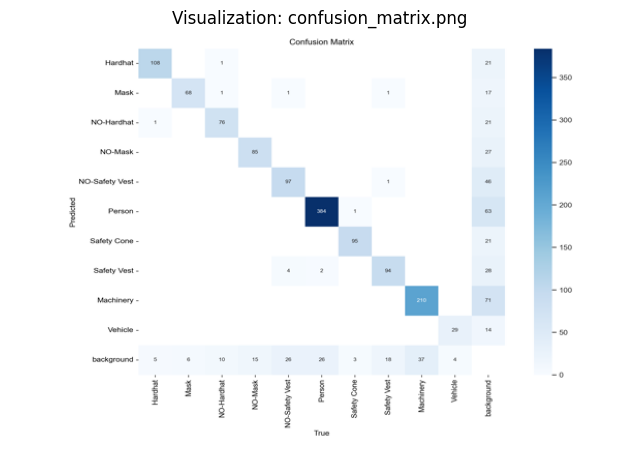

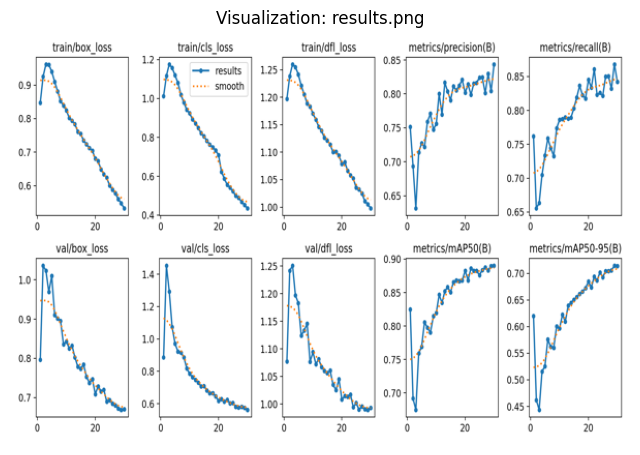

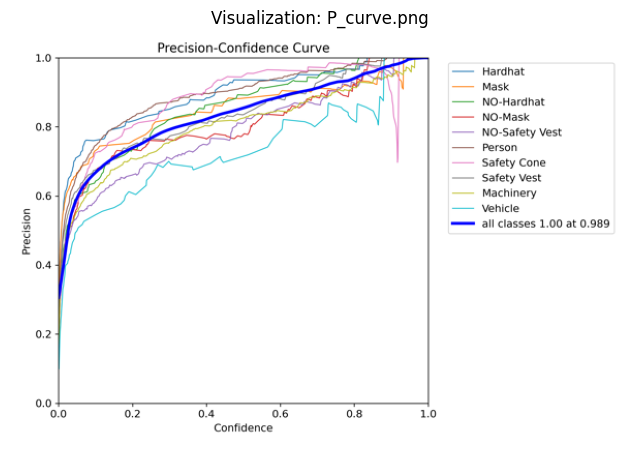

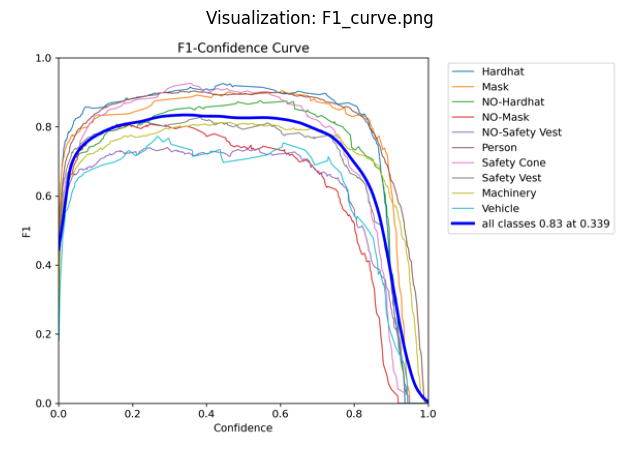

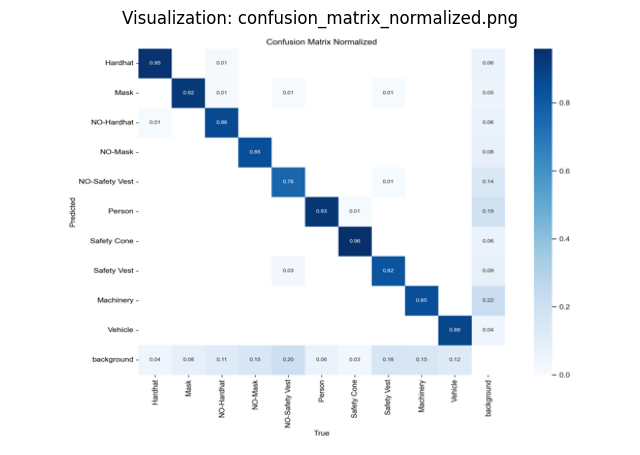

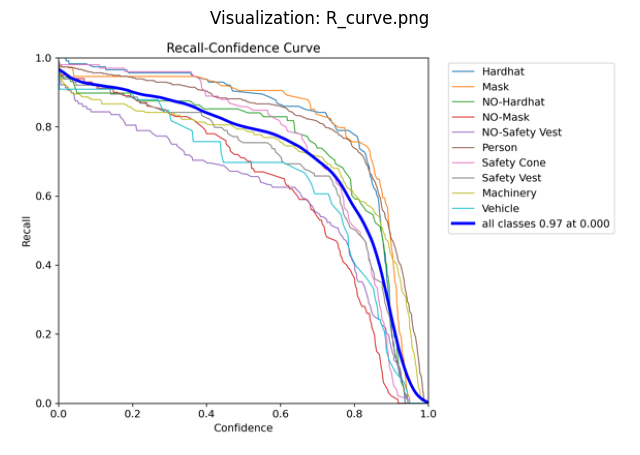

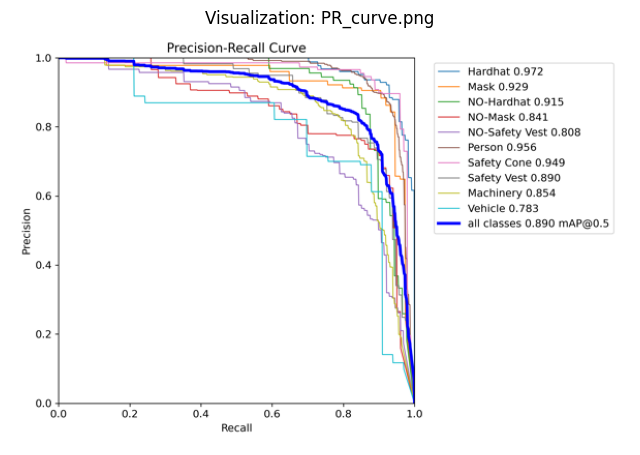

In [62]:

train_path = "runs/detect/train4"
# loop through image
png_files = [f for f in os.listdir(train_path) if f.endswith(".png")]

# Loop through each .png file and display it
for png_file in png_files:
    file_path = os.path.join(train_path, png_file)
    image = Image.open(file_path).resize((600, 400))
    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title(f"Visualization: {png_file}")
    plt.show()



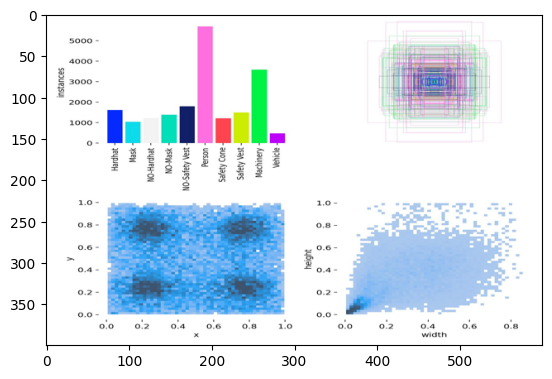

In [58]:
# Show labels and correlogram diagrams
labels = Image.open("runs/detect/train4/labels.jpg").resize((600,400))
plt.imshow(labels)


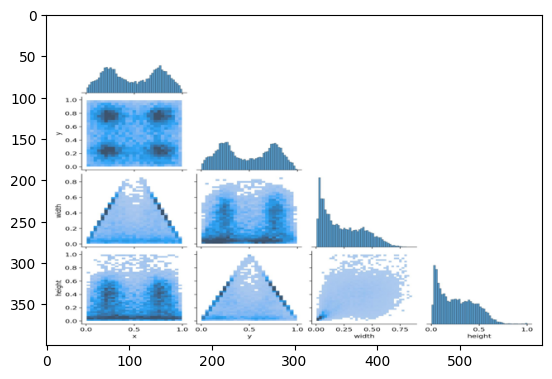

In [59]:
labels_corr = Image.open("runs/detect/train4/labels_correlogram.jpg").resize((600,400))
plt.imshow(labels_corr)

### Visualize prediction on test sets


image 1/1 /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/notebooks/../datasets/images/test/image_120_jpg.rf.40fce375a47fcd49ce6150a3fb2aa2a9.jpg: 640x640 1 Hardhat, 1 Person, 1 Safety Vest, 2 Machinerys, 1 Vehicle, 164.6ms
Speed: 0.6ms preprocess, 164.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


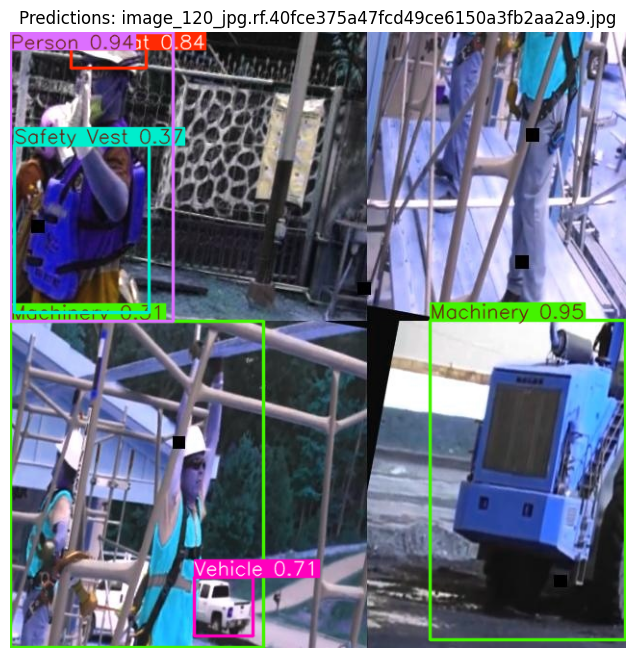


image 1/1 /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/notebooks/../datasets/images/test/youtube-175_jpg.rf.42efa8b28ba1ccb4779c2b169023c27d.jpg: 640x640 4 Persons, 1 Safety Vest, 2 Machinerys, 174.9ms
Speed: 1.0ms preprocess, 174.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


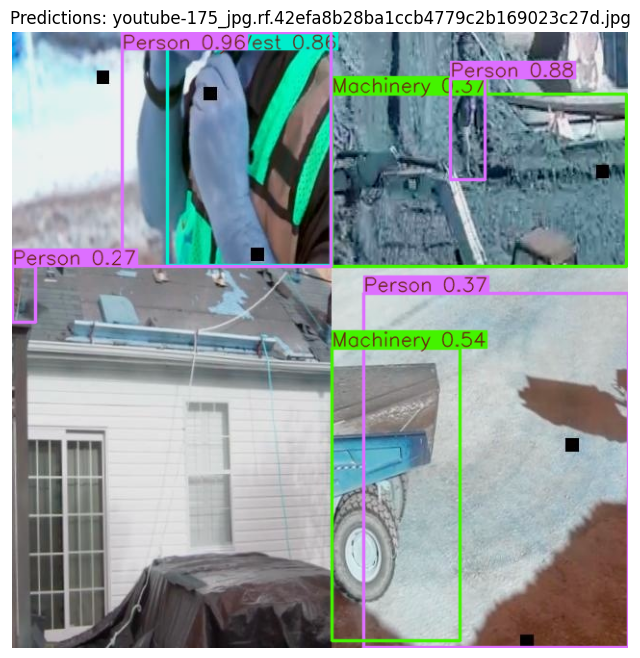


image 1/1 /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/notebooks/../datasets/images/test/mask-wearing-1632932085584_png_jpg.rf.4bf437edc7d0549c380eca13c47dbc53.jpg: 640x640 1 NO-Mask, 1 NO-Safety Vest, 2 Persons, 1 Safety Cone, 2 Safety Vests, 1 Vehicle, 174.5ms
Speed: 0.6ms preprocess, 174.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


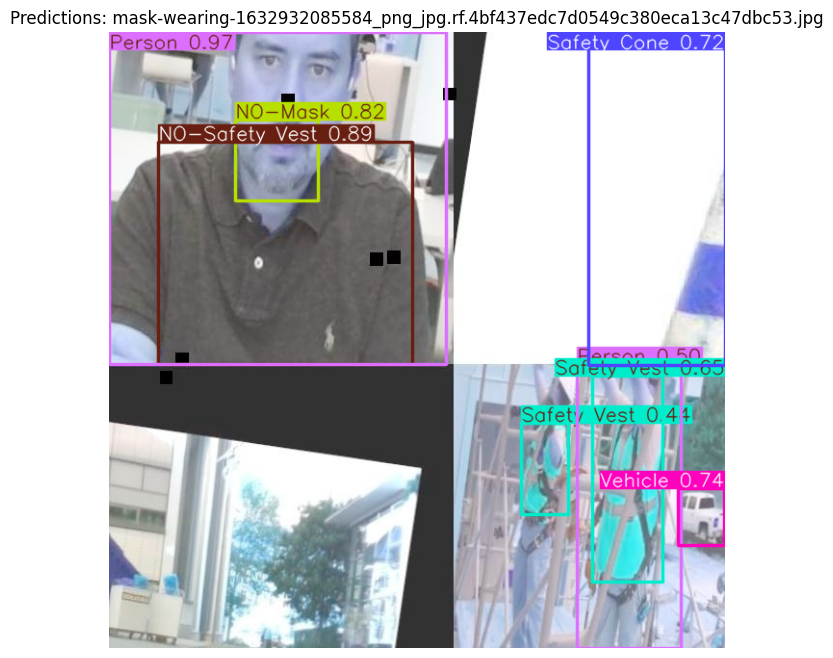

In [ ]:
# load the trained model
model = YOLO("runs/detect/train4/weights/best.pt")

# Path to test images
test_images_dir = "../datasets/images/test"

# get list of test images
test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# run inference and display predictions
# shuffle the images randomly
random.shuffle(test_images)

# limit to a subset 
test_images_subset = test_images[:3]

# Run inference and display predictions for random images
for test_image in test_images_subset:
    image_path = os.path.join(test_images_dir, test_image)
    results = model.predict(source=image_path, save=False)  # Run inference

    # Display the image with predictions
    img = results[0].plot()  # YOLOv8's built-in method to plot predictions
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predictions: {test_image}")
    plt.show()

### Evaluate model performance on test sets

In [39]:
results = model.val(data=dataset_yaml, split="test")
print(results)

Ultralytics 8.3.33 🚀 Python-3.11.9 torch-2.5.1 CPU (Apple M3 Pro)
Model summary (fused): 218 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/datasets/labels/test... 89 images, 3 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:00<00:00, 2917.92it/s]

val: New cache created: /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/datasets/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:41<00:00,  8.23s/it]


                   all         89        664      0.828      0.762      0.846      0.675
               Hardhat         33         47      0.934      0.787      0.897      0.748
                  Mask         29         44      0.824      0.773        0.9      0.766
            NO-Hardhat         39         61      0.876      0.803      0.882      0.707
               NO-Mask         28         40      0.681       0.65       0.74      0.533
        NO-Safety Vest         50         72      0.816      0.722      0.836      0.659
                Person         78        192      0.906      0.855      0.927      0.811
           Safety Cone         15         43      0.867      0.674      0.796      0.545
           Safety Vest         28         38      0.765      0.789      0.793      0.627
             Machinery         58        118      0.836      0.814      0.888      0.765
               Vehicle          5          9      0.771       0.75      0.801      0.593
Speed: 0.6ms preproce